# Projeto e análise de filtros digitais (2024/1)

* Prof: Carlos Speranza
* Aluno: João Mário Carnieletto Izoton Lago

## Introdução

Os filtros digitais são fundamentais no processamento de sinais digitais e são amplamente aplicados em áreas como comunicações sem fio e processamento de áudio. Eles desempenham um papel vital na extração, modificação e análise de informações contidas em sinais digitais, oferecendo uma grande flexibilidade e eficiência no ambiente digital.

Esses filtros podem ser classificados em duas categorias principais: filtros de resposta ao impulso infinita (IIR) e filtros de resposta ao impulso finita (FIR). Os filtros IIR se diferenciam dos FIR por apresentarem uma resposta ao impulso que se estende indefinidamente, devido à realimentação presente em sua estrutura interna. Por essa razão, os filtros IIR tendem a ser mais eficientes em termos de recursos computacionais, tornando-os ideais para sistemas onde o processamento precisa ser mais econômico.

Em contrapartida, os filtros FIR têm uma resposta ao impulso com duração limitada, o que significa que não possuem realimentação. Essa característica faz com que os filtros FIR sejam mais previsíveis e estáveis em comparação com os filtros IIR. Apesar de demandarem maior capacidade de processamento, os filtros FIR são geralmente preferidos em aplicações que exigem alta precisão e uma resposta de fase linear. A escolha entre um filtro IIR ou FIR dependerá das exigências específicas da aplicação, equilibrando as necessidades de processamento, estabilidade e as características desejadas do filtro.

## Objetivos

Este trabalho tem por objetivo fazer a implementação de 4 filtros digitais, sendo 2 FIR e 2 IIR. Com eles implementados, será feito sua análise no domínio da frequência.

Os filtros terão as seguintes especificações:
- Filtro Passa-Alta (FPA)
  - Frequência de amostragem: 8 kHz

  - Banda Passante: 3.2 a fs/2 kHz, com ondulação máxima de 1 dB
  - Banda de Rejeição: 0 a 2.9 kHz, com atenuação mínima de 52 dB

  - FIR: Kaiser e outra janela que atender especificação
  - IIR: Protótipo Chebyschev II e Elíptico

## Metodologia

Este projeto foi realizado com o auxílio de livros didáticos, conteúdos abordados em aula e códigos em Python disponibilizados pelo professor.

Inicialmente, foram definidos os parâmetros básicos em cada código, como a frequência de amostragem, a banda passante e a banda de rejeição. Estabelecer esses parâmetros de forma clara facilitou a replicação dessas informações em todos os filtros desenvolvidos.

Com os parâmetros definidos, cada código foi criado com base no filtro específico e na sua melhor aplicação. Finalmente, as informações coletadas de cada filtro foram usadas para comparar os diferentes filtros, levando em consideração suas ordens e o número de multiplicações envolvidas.

### Especificações do Filtro

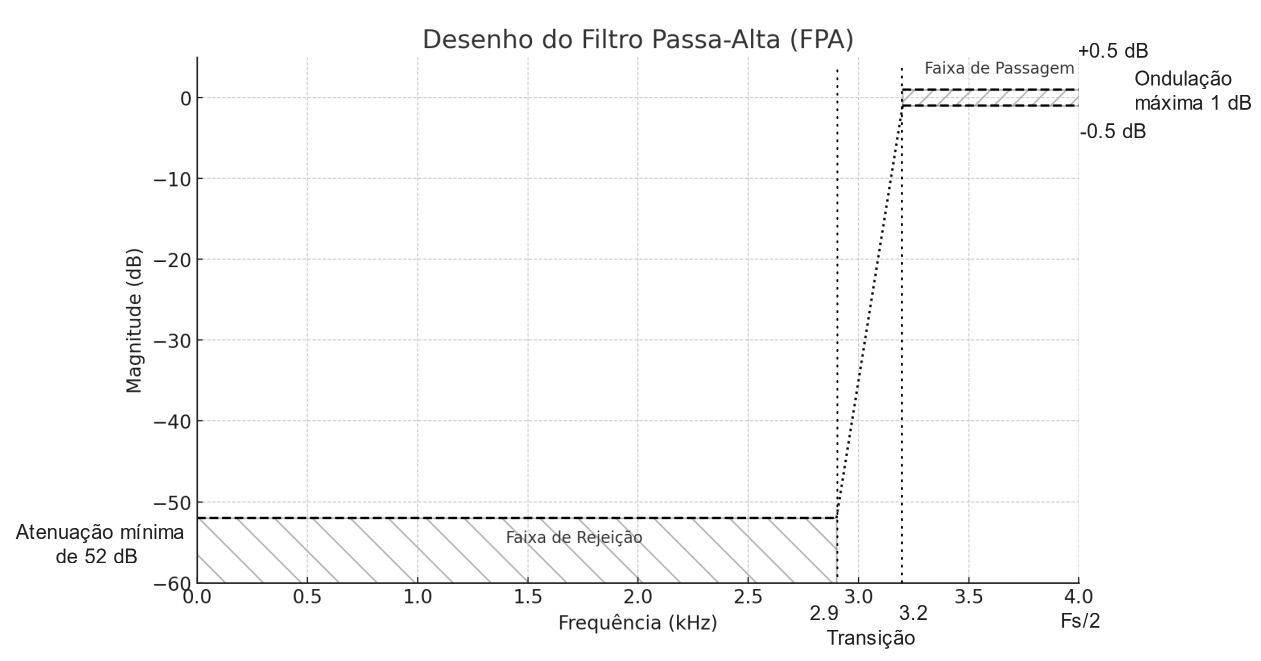

### Implementação em Python

#### Bibliotecas

In [1]:
%pip install -q numpy matplotlib scipy sympy


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from fDSP_filtros import freqz_m, QCoeff
from plot_zplane import zplane
from IPython.display import display, Markdown

#### Utils

In [3]:
from typing import Dict
from dataclasses import dataclass

# Ignore runtime warnings
import warnings
warnings.filterwarnings('ignore')

@dataclass
class FilterData:
    name: str

    h: np.ndarray
    fs: float

    ripple_calculado: float
    attenuation_calculado: float
    ripple_calculado_8bits: float
    attenuation_calculado_8bits: float
    ripple_calculado_16bits: float
    attenuation_calculado_16bits: float

    M: int
    order: int
    multiplications: int

    def __str__(self):
        return f'FilterData({self.name}, {self.h}, {self.fs}, {self.ripple_calculado}, {self.attenuation_calculado}, {self.ripple_calculado_8bits}, {self.attenuation_calculado_8bits}, {self.ripple_calculado_16bits}, {self.attenuation_calculado_16bits}, {self.M})'


filters_data: Dict[str, 'FilterData'] = {}


def compute_filter_order(b, a=None):
    display(Markdown("Para determinar a ordem do filtro, vamos examinar o número de coeficientes presentes nos vetores fornecidos."))
    if a is None:
        display(Markdown(f"O filtro FIR contém {len(b)} coeficientes no numerador."))
        display(Markdown(f"Assim, a ordem do filtro FIR é $M = len(b) - 1 = {len(b) - 1}$."))
        # Calcula a ordem do filtro FIR
        M = len(b) - 1
    else:
        display(Markdown(f"O filtro tem {len(b)} coeficientes no numerador e {len(a)} coeficientes no denominador."))
        display(Markdown(f"Portanto, a ordem do filtro é $M = max(len(b), len(a)) - 1 = {max(len(b), len(a)) - 1}$."))
        # Calcula a ordem do filtro
        M = max(len(b), len(a)) - 1
    return M


def compute_filter_multiplications(b, a=None):
    # Avalia a quantidade de coeficientes relevantes, ignorando aqueles que são zero
    display(Markdown(
        "Para determinar o número de multiplicações, vamos considerar a quantidade de coeficientes não nulos nos vetores de coeficientes."
        "Desconsiderando o primeiro coeficiente, pois a multiplicação por 1 não é necessária.")
        )

    M = 0
    for i in b:
        if not np.isclose(i, 0.0, atol=1e-33):
            M += 1

    N = 0
    if a is not None:
        for i in a:
            if not np.isclose(i, 0.0, atol=1e-33):
                N += 1

    if a is None:
        display(Markdown(f"O filtro FIR tem {M} coeficientes não nulos no numerador."))
        display(Markdown(f"Portanto, o número de multiplicações necessárias para implementar o filtro FIR é $M - 1 = {M - 1}$."))
        return M - 1
    else:
        display(Markdown(f"O filtro possui {M} coeficientes não nulos no numerador e {N} coeficientes não nulos no denominador."))
        display(Markdown(f"Logo, o número de multiplicações necessárias para implementar o filtro é $N - 1 + M - 1 = {N - 1 + M - 1}$."))
        return N - 1 + M - 1


def plot_filter_responses(
    h,
    fs,
    pass_max_oscillation,
    stop_min_attenuation,
    w_pass_min,
    w_pass_max,
    w_stop_max,
    filter_name,
    is_iir=False,
    a = None,
    M = None,
    N = None
) -> None:
    """
    Plota as respostas em frequência do filtro.

    Args:
        h (array): Coeficientes do filtro.
        fs (int): Frequência de amostragem.
        pass_max_oscillation (float): Ondulação máxima na banda de passagem.
        stop_min_attenuation (float): Atenuação mínima na banda de rejeição.
        w_pass_min (float): Frequência mínima da banda de passagem.
        w_stop_max (float): Frequência máxima da banda de rejeição.
        filter_name (str): Nome do filtro.
        is_iir (bool): Se o filtro é IIR.
        a (array): Coeficientes do filtro IIR.
        M (int): Número de coeficientes do filtro.
        N (int): Ordem do filtro.
    """

    if is_iir:
        [db, mag, pha, grd, w] = freqz_m(h, a)
    else:
        [db, mag, pha, grd, w] = freqz_m(h, 1)

    delta_w = np.pi / (len(w) - 1)

    # Cálculo da ondulação (Rp) na banda passante
    ripple_calculado = max(
        -np.min(db[int(w_pass_min/delta_w):]),
        np.max(db[int(w_pass_min/delta_w):])
    )

    # Cálculo da atenuação (As) nas bandas de rejeição
    attenuation_calculado = -np.max(db[0:int(w_stop_max/delta_w+1)])

    # Resposta em magnitude
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 12))

    # Plot geral da resposta em magnitude
    axs[0].set_title('Resposta em Magnitude')
    axs[0].plot(w/np.pi, mag)
    axs[0].axhline(-stop_min_attenuation, color='r', linestyle=':', label=f'Atenuação (As = {stop_min_attenuation} dB)')
    axs[0].axvline(w_pass_min/np.pi, color='g', linestyle='--', label=f'w_pass_min = {w_pass_min/np.pi:.2f} π')
    axs[0].axvline(w_stop_max/np.pi, color='b', linestyle=':', label=f'w_stop_max = {w_stop_max/np.pi:.2f} π')
    axs[0].grid()
    axs[0].set_xlabel("Frequência (π rad/sample)")
    axs[0].set_ylabel("|H|")
    axs[0].legend()
    axs[0].axis([0, 1, 0, 1.1])

    # Plot da resposta em dB
    axs[1].set_title("Resposta Magnitude em dB")
    axs[1].plot(w/np.pi, db)
    axs[1].grid()
    axs[1].axhline(-pass_max_oscillation, color='r', linestyle='--')
    axs[1].axhline(pass_max_oscillation, color='r', linestyle='--')
    axs[1].axhline(-stop_min_attenuation, color='r', linestyle=':')
    axs[1].axvline(w_pass_min/np.pi, color='g', linestyle='--')
    axs[1].axvline(w_stop_max/np.pi, color='b', linestyle=':')
    axs[1].set_xlabel("Frequência (π rad/sample)")
    axs[1].set_ylabel("Magnitude (dB)")
    axs[1].axis([0, 1, -80, 5])

    # Zoom na faixa passante
    axs[2].set_title(f"Zoom na Faixa Passante {w_pass_min/np.pi}π - {w_pass_max}π")
    axs[2].plot(w/np.pi, db)
    axs[2].grid()
    axs[2].axhline(-pass_max_oscillation, color='r', linestyle='--')
    axs[2].axhline(pass_max_oscillation, color='r', linestyle='--')
    axs[2].axvline(w_pass_min/np.pi, color='g', linestyle='--')
    axs[2].axvline(w_pass_max/np.pi, color='g', linestyle='--')
    axs[2].set_xlabel("Frequência (π rad/sample)")
    axs[2].set_ylabel("Magnitude (dB)")
    axs[2].axis([(w_pass_min/np.pi) - 0.1, (w_pass_max/np.pi) + 0.1, -pass_max_oscillation-1, pass_max_oscillation+1])

    fig.tight_layout()
    plt.show()

    # Resposta de fase e Atraso de grupo
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

    # Removendo singularidades no atraso de grupo
    # Filtrando o atraso de grupo
    filtered_grd = signal.medfilt(grd, 9)

    max_grd = np.max(filtered_grd)
    min_grd = np.min(filtered_grd)
    axs[0].set_title("Resposta de Fase")
    axs[0].plot(w/np.pi, pha)
    axs[0].grid()
    axs[0].set_xlabel("Frequência (π rad/sample)")
    axs[0].set_ylabel("Fase (rads)")

    axs[1].set_title("Atraso de Grupo")
    axs[1].plot(w/np.pi, grd)
    axs[1].grid()
    axs[1].set_xlabel("Frequência (π rad/sample)")
    axs[1].set_ylabel("Atraso de Grupo (amostras)")
    # Limitando o eixo y para melhor visualização
    axs[1].axis([0, 1, min_grd-1, max_grd+1])

    fig.tight_layout()
    plt.show()

    # Quantização dos coeficientes ponto-fixo 8 bits
    N1 = 7
    [bhat1, L1, B1] = QCoeff(h, N1)
    ahat1 = QCoeff(a, N1)[0] if is_iir else [1, 0]

    [dbhat1, maghat1, phahat1, grdhat1, w] = freqz_m(bhat1, ahat1)

    # Ondulação e atenuação calculadas para a precisão de 8 bits
    ripple_calculado_8bits = max(
        -np.min(dbhat1[int(w_pass_min/delta_w):]),
        np.max(dbhat1[int(w_pass_min/delta_w):])
    )
    attenuation_calculado_8bits = -np.max(dbhat1[0:int(w_stop_max/delta_w+1)])

    # Quantização dos coeficientes ponto-fixo 16 bits
    N2 = 15
    [bhat2, L2, B2] = QCoeff(h, N2)
    ahat2 = QCoeff(a, N2)[0] if is_iir else [1, 0]

    [dbhat2, maghat2, phahat2, grdhat2, w] = freqz_m(bhat2, ahat2)

    # Ondulação e atenuação calculadas para a precisão de 16 bits
    ripple_calculado_16bits = max(
        -np.min(dbhat2[int(w_pass_min/delta_w):]),
        np.max(dbhat2[int(w_pass_min/delta_w):])
    )

    attenuation_calculado_16bits = -np.max(dbhat2[0:int(w_stop_max/delta_w+1)])

    # Diagrama de polos e zeros para diferentes precisões
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].set_title("Diagrama de Polos e Zeros")
    zplane(h, a if is_iir else [1, 0], ax=axs[0])

    axs[1].set_title(f"Precisão {int(1+L1+B1)} bits (1+{int(L1)}+{int(B1)})")
    zplane(bhat1, ahat1, ax=axs[1])

    axs[2].set_title(f"Precisão {int(1+L2+B2)} bits (1+{int(L2)}+{int(B2)})")
    zplane(bhat2, ahat2, ax=axs[2])

    plt.tight_layout()
    plt.show()

    # Resposta em magnitude precisão de 8 bits e 16 bits
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    frase4 = f"Magnitude: {int(1+L1+B1)} bits (1+{int(L1)}+{int(B1)})"
    axs[0].set_title(frase4)
    axs[0].plot(w/np.pi, db, 'k', label='Precisão Infinita', linestyle='--')
    axs[0].plot(w/np.pi, dbhat1, 'b', label='8 bits')
    axs[0].legend(loc='best')
    axs[0].grid()
    axs[0].set_xlabel("Frequência (π rad/sample)")
    axs[0].set_ylabel("Magnitude (dB)")
    axs[0].axis([0, 1, -80, 5])
    axs[0].axvline(w_pass_min/np.pi, color='r', linestyle='--')
    axs[0].axvline(w_stop_max/np.pi, color='r', linestyle='--')

    frase5 = f"Magnitude: {int(1+L2+B2)} bits (1+{int(L2)}+{int(B2)})"
    axs[1].set_title(frase5)
    axs[1].plot(w/np.pi, db, 'k', label='Precisão Infinita', linestyle='--')
    axs[1].plot(w/np.pi, dbhat2, 'b', label='16 bits')
    axs[1].legend(loc='best')
    axs[1].grid()
    axs[1].set_xlabel("Frequência (π rad/sample)")
    axs[1].set_ylabel("Magnitude (dB)")
    axs[1].axis([0, 1, -80, 5])
    axs[1].axvline(w_pass_min/np.pi, color='r', linestyle='--')
    axs[1].axvline(w_stop_max/np.pi, color='r', linestyle='--')

    fig.tight_layout()

    plt.show()

    tabela_markdown = ('| **Filtro** | **Quantização** | **Ondulação (dB)** | **Atenuação (dB)** |\n'
                    '|:-----------:|:---------------:|:------------------:|:------------------:|\n'
                    f'| {filter_name} | Infinita | {ripple_calculado:.2f} | {attenuation_calculado:.2f} |\n'
                    f'| {filter_name} | 8 bits | {ripple_calculado_8bits:.2f} | {attenuation_calculado_8bits:.2f} |\n'
                    f'| {filter_name} | 16 bits | {ripple_calculado_16bits:.2f} | {attenuation_calculado_16bits:.2f} |\n'
    )

    display(Markdown(tabela_markdown))

    display(Markdown(f"\n#### Calculo da ordem e multiplicações do filtro\n"))

    # Calcula a ordem do filtro
    order = compute_filter_order(h, a)

    # Calcula o número de multiplicações
    multiplications = compute_filter_multiplications(h, a)

    # Salva os dados do filtro
    filters_data[filter_name] = FilterData(filter_name, h, fs, float(ripple_calculado), float(attenuation_calculado), float(ripple_calculado_8bits), float(attenuation_calculado_8bits), float(ripple_calculado_16bits), float(attenuation_calculado_16bits), M, order, multiplications)


#### Parâmetros do filtro

In [4]:
# Amostragem
fs = 8e3     # Hz
T = 1.0 / fs # s

# Banda de passagem
f_pass_min = 3.2e3      # Hz
f_pass_max = fs / 2.0   # Hz
pass_max_oscillation = 1 # dB

w_pass_min = 2 * np.pi * f_pass_min * T # rad/sample
w_pass_max = 2 * np.pi * f_pass_max * T # rad/sample

# Banda de rejeição
f_stop_min = 0            # Hz
f_stop_max = 2.9e3        # Hz
stop_min_attenuation = 52 # dB

w_stop_min = 2 * np.pi * f_stop_min * T # rad/sample
w_stop_max = 2 * np.pi * f_stop_max * T # rad/sample

###  Filtro Kaiser

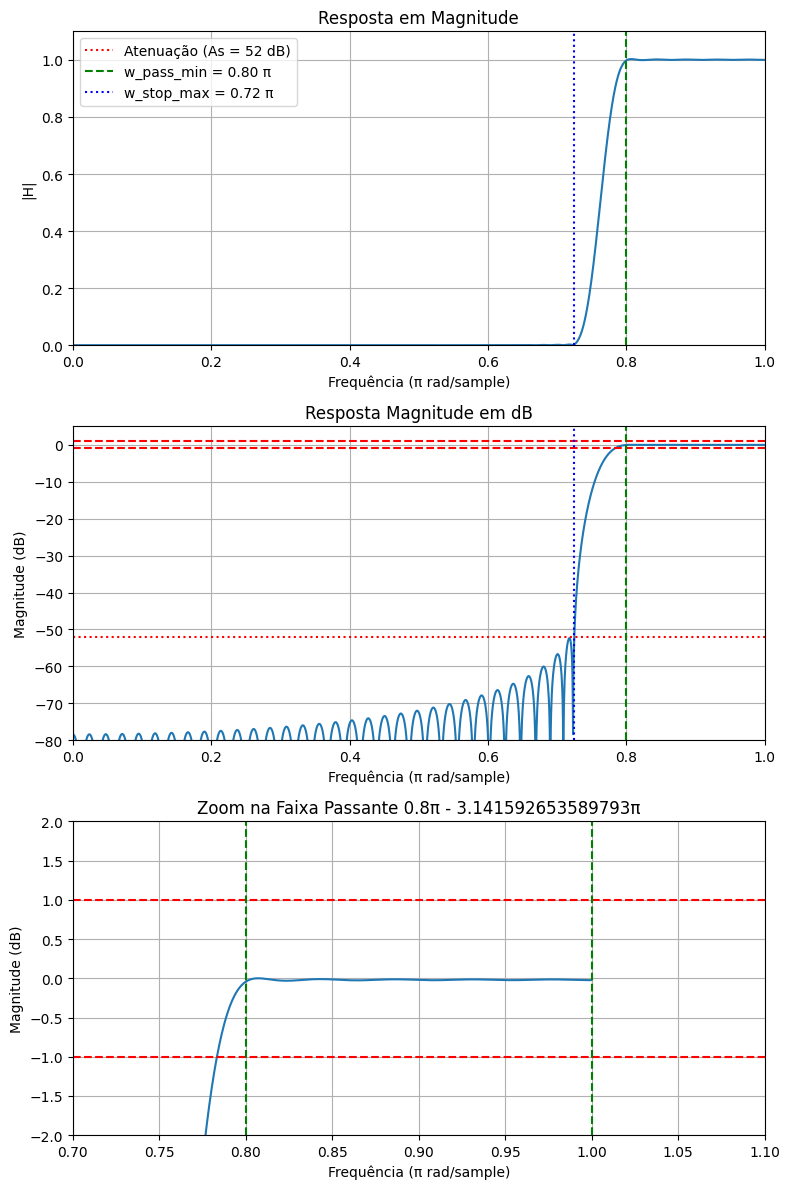

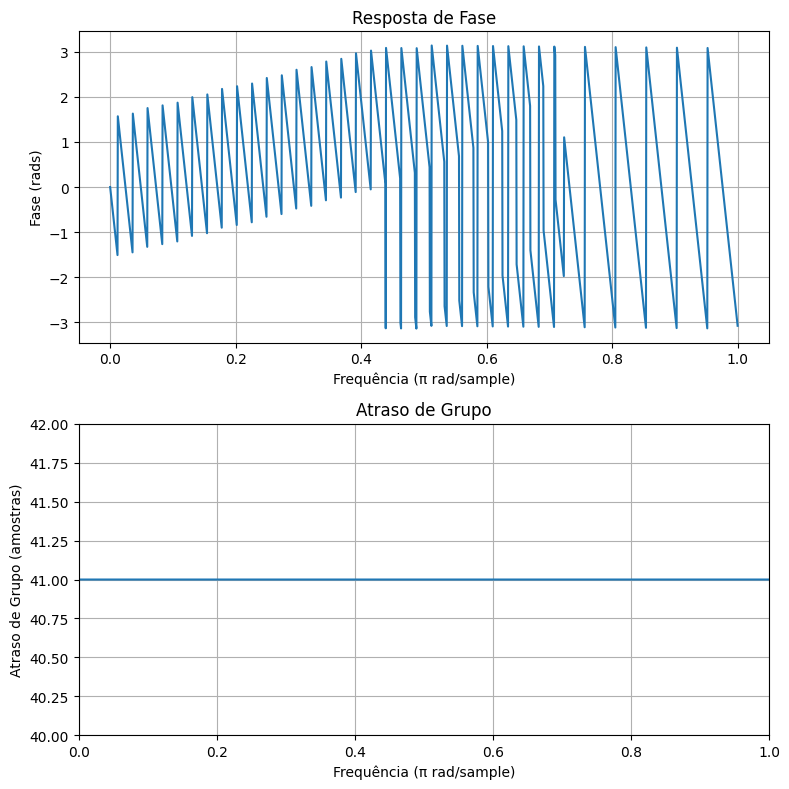

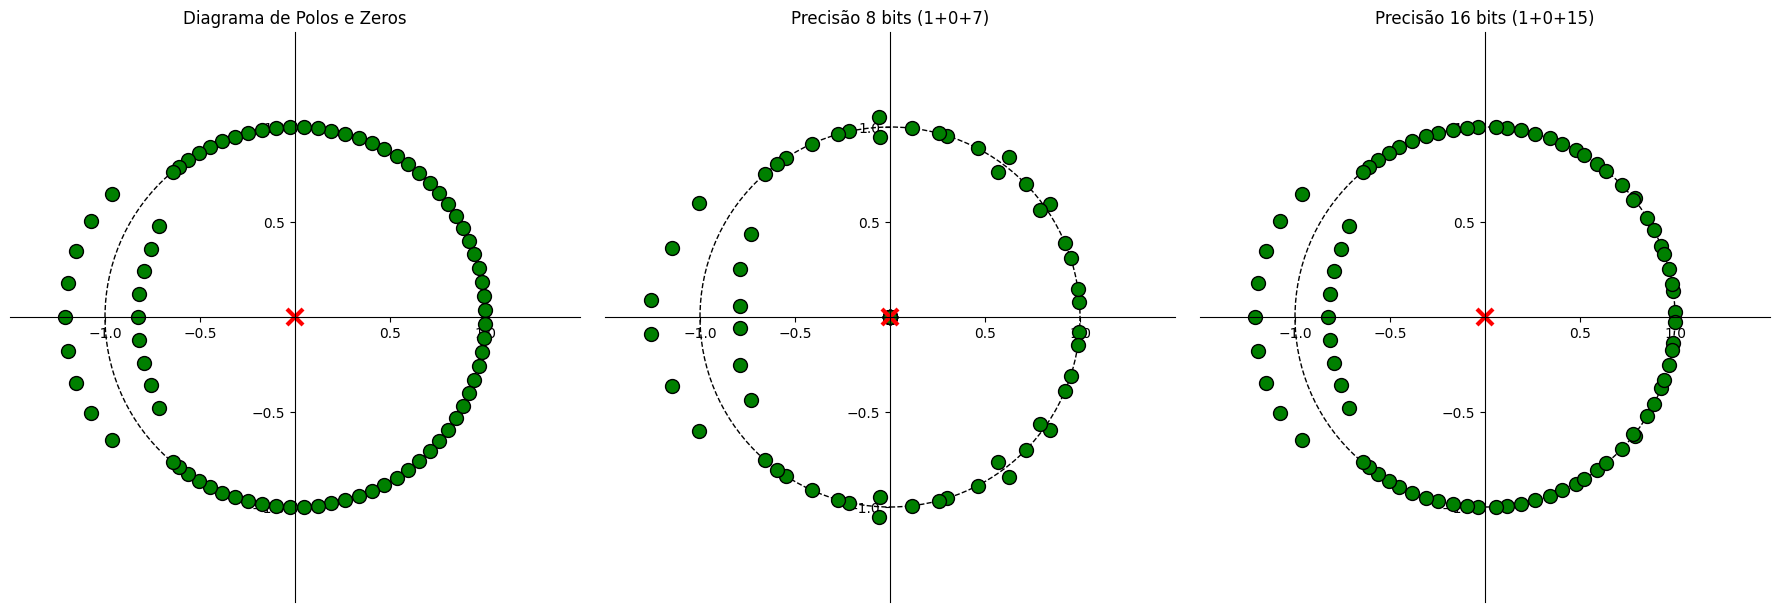

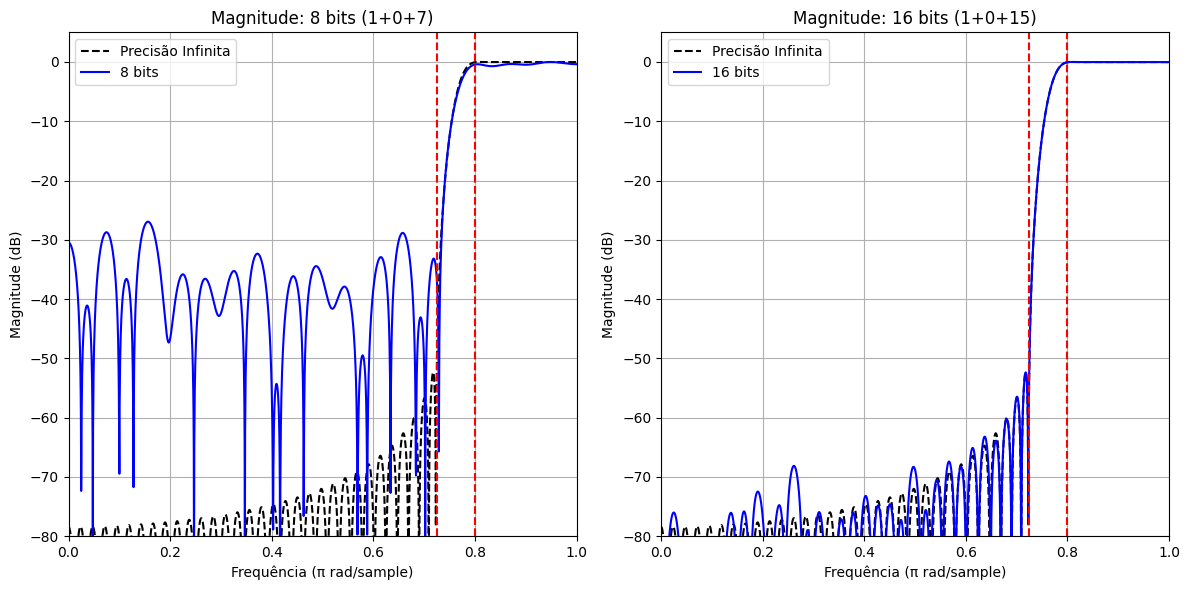

| **Filtro** | **Quantização** | **Ondulação (dB)** | **Atenuação (dB)** |
|:-----------:|:---------------:|:------------------:|:------------------:|
| fir_kaiser | Infinita | 0.05 | 52.35 |
| fir_kaiser | 8 bits | 0.71 | 26.94 |
| fir_kaiser | 16 bits | 0.05 | 52.36 |



#### Calculo da ordem e multiplicações do filtro


Para determinar a ordem do filtro, vamos examinar o número de coeficientes presentes nos vetores fornecidos.

O filtro FIR contém 83 coeficientes no numerador.

Assim, a ordem do filtro FIR é $M = len(b) - 1 = 82$.

Para determinar o número de multiplicações, vamos considerar a quantidade de coeficientes não nulos nos vetores de coeficientes.Desconsiderando o primeiro coeficiente, pois a multiplicação por 1 não é necessária.

O filtro FIR tem 83 coeficientes não nulos no numerador.

Portanto, o número de multiplicações necessárias para implementar o filtro FIR é $M - 1 = 82$.

#### Analisando as respostas do filtro



Para projetar o filtro passa-alta, foi utilizado o método de janelamento de Kaiser. Primeiramente, calculou-se a ordem mínima do filtro M com base nas especificações do projeto, resultando em M = 83, através da função `kaiserord`. Em seguida, determinou-se o valor de beta, parâmetro da janela de Kaiser, utilizando também a função `kaiserord`, obtendo-se $beta = 4.7717$. Finalmente, o filtro foi projetado utilizando a função `signal.firwin`, gerando os coeficientes do filtro passa-alta 

h = [ 2.56624543e-04 -4.63403600e-04  4.36982560e-04 -5.85358332e-05
 -5.68327650e-04  1.09890169e-03 -1.10725862e-03  3.68187688e-04
  9.04509788e-04 -2.05023093e-03  2.26428203e-03 -1.09691659e-03
 -1.13446917e-03  3.32371314e-03 -4.06875450e-03  2.49387218e-03
  1.04782697e-03 -4.87536049e-03  6.69759793e-03 -4.89137113e-03
 -3.29605611e-04  6.60792932e-03 -1.03829043e-02  8.77984693e-03
 -1.50767657e-03 -8.37824514e-03  1.55473874e-02 -1.50527718e-02
  5.34847828e-03  1.00145255e-02 -2.32648916e-02  2.58970253e-02
 -1.33629018e-02 -1.13411058e-02  3.73042679e-02 -4.93135461e-02
  3.42864196e-02  1.22060970e-02 -8.24272944e-02  1.57949127e-01
 -2.15910192e-01  2.37624724e-01 -2.15910192e-01  1.57949127e-01
 -8.24272944e-02  1.22060970e-02  3.42864196e-02 -4.93135461e-02
  3.73042679e-02 -1.13411058e-02 -1.33629018e-02  2.58970253e-02
 -2.32648916e-02  1.00145255e-02  5.34847828e-03 -1.50527718e-02
  1.55473874e-02 -8.37824514e-03 -1.50767657e-03  8.77984693e-03
 -1.03829043e-02  6.60792932e-03 -3.29605611e-04 -4.89137113e-03
  6.69759793e-03 -4.87536049e-03  1.04782697e-03  2.49387218e-03
 -4.06875450e-03  3.32371314e-03 -1.13446917e-03 -1.09691659e-03
  2.26428203e-03 -2.05023093e-03  9.04509788e-04  3.68187688e-04
 -1.10725862e-03  1.09890169e-03 -5.68327650e-04 -5.85358332e-05
  4.36982560e-04 -4.63403600e-04  2.56624543e-04].

Pode-se notar que a qualidade do filtro sofre mais com a representação de 8 bits em comparação com a de 16 bits, como fica evidente na distribuição dos zeros no diagrama de polos e zeros. 

Em termos de magnitude, a quantização em 8 bits resulta em uma maior instabilidade, refletida na diferença entre as respostas observadas (em preto) e as respostas esperadas (em azul). Ao analisar a resposta em magnitude do filtro quantizado em 8 bits, observa-se uma atenuação de cerca de 30 dB, inferior à atenuação de 40 dB exigida. Em contraste, a quantização em 16 bits gera respostas muito próximas das esperadas, mantendo o filtro dentro da faixa de atenuação desejada.

In [5]:
# Larguras de transição
tr_width1 = abs(w_pass_min - w_stop_max)

# Calculando a ordem do filtro usando scipy.signal.kaiserord
tr_width = tr_width1 / np.pi
M, beta = signal.kaiserord(stop_min_attenuation, tr_width)

# Frequências de corte
wc1 = (w_pass_min + w_stop_max) / 2.0

h = signal.firwin(M, [wc1 / np.pi], window=('kaiser', beta), pass_zero=False, scale=True)

[db, mag, pha, grd, w] = freqz_m(h, 1)


# Texto para o relatório


plot_filter_responses(h, fs, pass_max_oscillation, stop_min_attenuation, w_pass_min, w_pass_max, w_stop_max, 'fir_kaiser', is_iir=False)

display(Markdown("#### Analisando as respostas do filtro\n\n"))

display(Markdown(f"Para projetar o filtro passa-alta, foi utilizado o método de janelamento de Kaiser. "
                 f"Primeiramente, calculou-se a ordem mínima do filtro M com base nas especificações do projeto, "
                 f"resultando em M = {M}, através da função `kaiserord`. Em seguida, determinou-se o valor de beta, "
                 f"parâmetro da janela de Kaiser, utilizando também a função `kaiserord`, obtendo-se $beta = {beta:.4f}$. "
                 f"Finalmente, o filtro foi projetado utilizando a função `signal.firwin`, gerando os coeficientes "
                 f"do filtro passa-alta \n\nh = {h}."))

display(Markdown(f"Pode-se notar que a qualidade do filtro sofre mais com a representação de 8 bits em comparação "
                 f"com a de 16 bits, como fica evidente na distribuição dos zeros no diagrama de polos e zeros. \n\n"
                 f"Em termos de magnitude, a quantização em 8 bits resulta em uma maior instabilidade, refletida na "
                 f"diferença entre as respostas observadas (em preto) e as respostas esperadas (em azul). "
                 f"Ao analisar a resposta em magnitude do filtro quantizado em 8 bits, observa-se uma atenuação de "
                 f"cerca de 30 dB, inferior à atenuação de 40 dB exigida. Em contraste, a quantização em 16 bits gera "
                 f"respostas muito próximas das esperadas, mantendo o filtro dentro da faixa de atenuação desejada."))


### Filtro Hamming

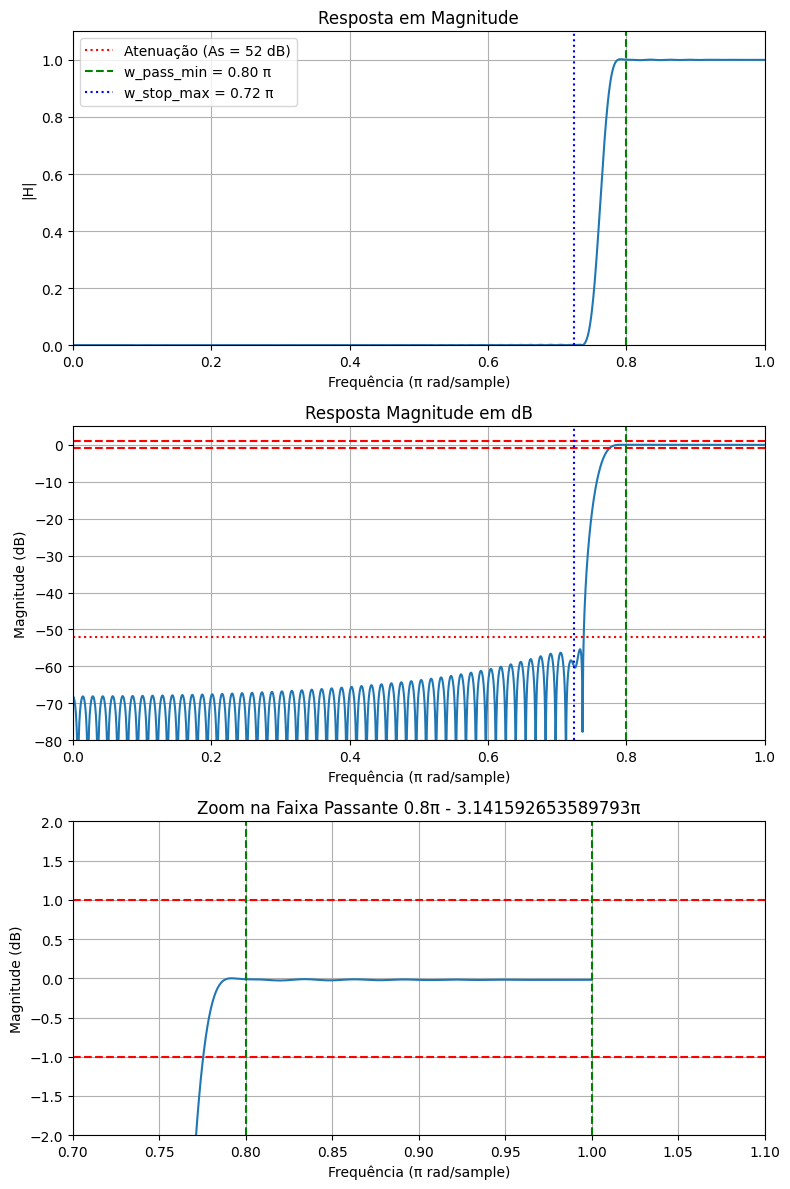

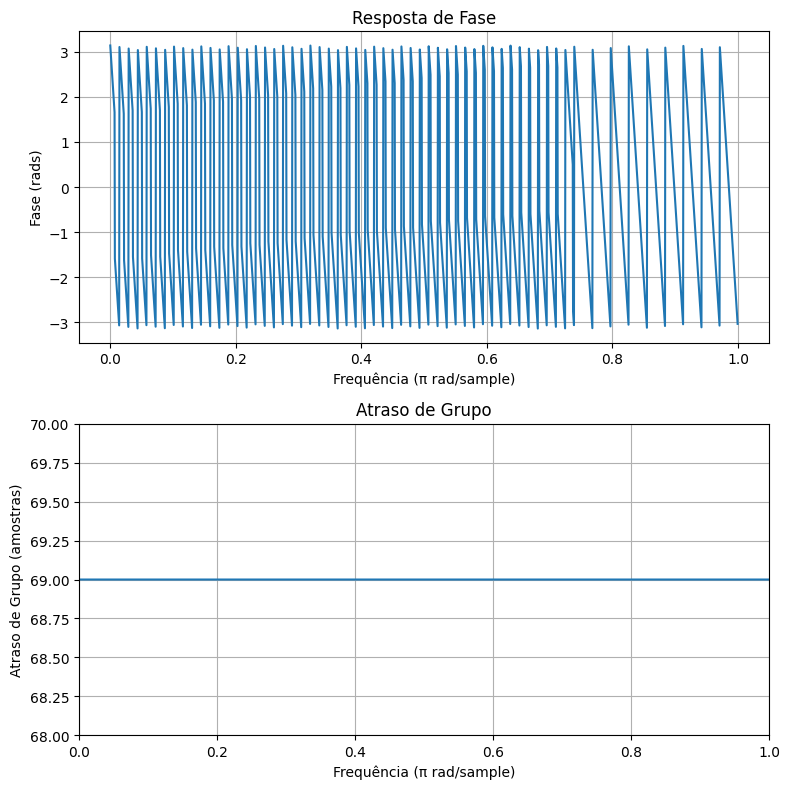

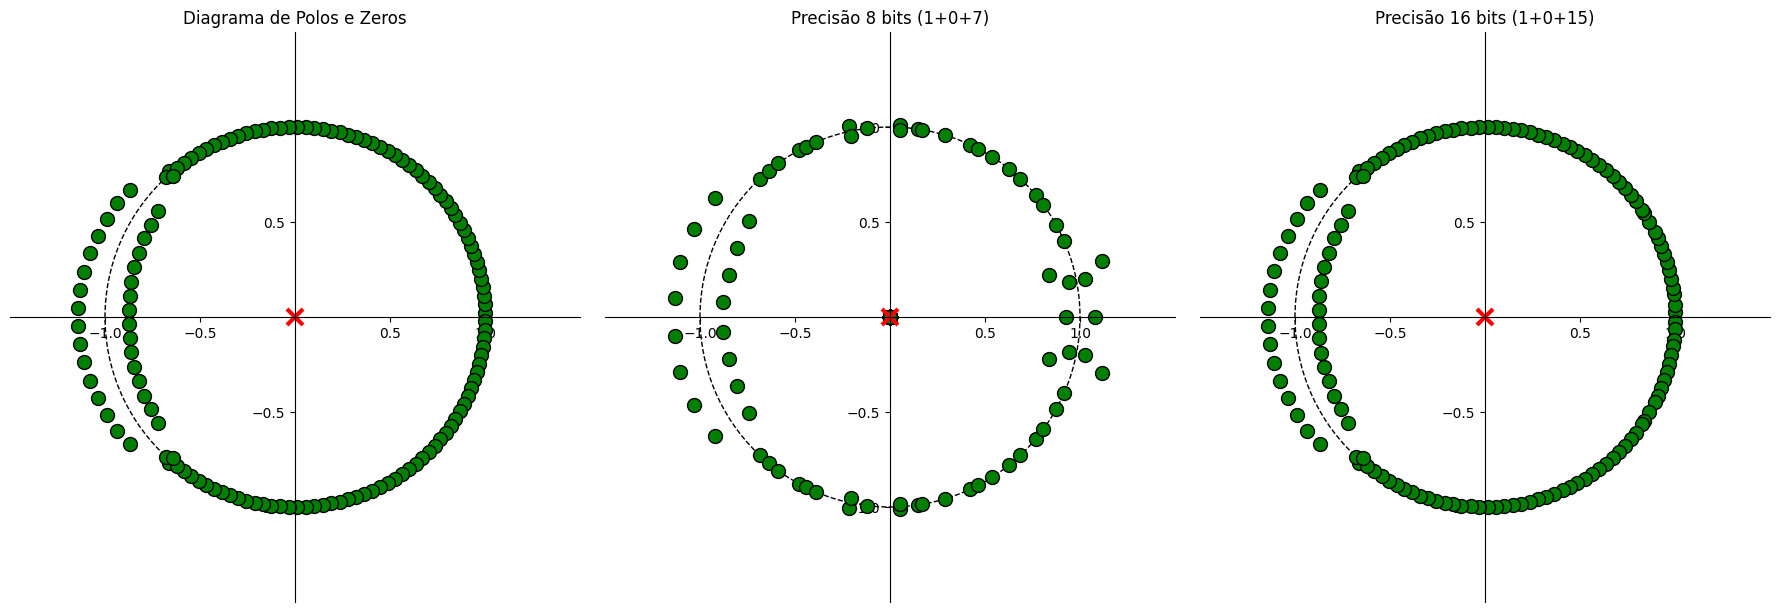

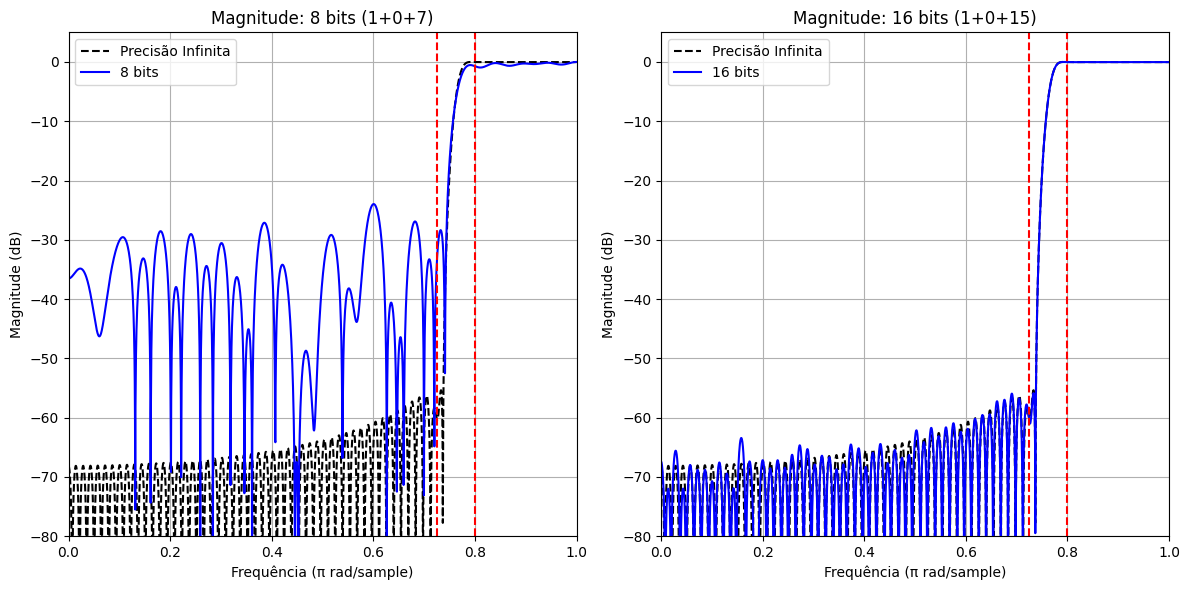

| **Filtro** | **Quantização** | **Ondulação (dB)** | **Atenuação (dB)** |
|:-----------:|:---------------:|:------------------:|:------------------:|
| fir_hamming | Infinita | 0.03 | 56.30 |
| fir_hamming | 8 bits | 0.94 | 23.97 |
| fir_hamming | 16 bits | 0.03 | 55.95 |



#### Calculo da ordem e multiplicações do filtro


Para determinar a ordem do filtro, vamos examinar o número de coeficientes presentes nos vetores fornecidos.

O filtro FIR contém 139 coeficientes no numerador.

Assim, a ordem do filtro FIR é $M = len(b) - 1 = 138$.

Para determinar o número de multiplicações, vamos considerar a quantidade de coeficientes não nulos nos vetores de coeficientes.Desconsiderando o primeiro coeficiente, pois a multiplicação por 1 não é necessária.

O filtro FIR tem 139 coeficientes não nulos no numerador.

Portanto, o número de multiplicações necessárias para implementar o filtro FIR é $M - 1 = 138$.

#### Analisando as respostas do filtro



Para projetar o filtro passa-alta, utilizou-se a janela de Hamming. Primeiramente, calculou-se a ordem do filtro M com base nas especificações do projeto, resultando em M = 139. Em seguida, utilizou-se a função `signal.firwin` para projetar o filtro FIR, obtendo-se os coeficientes do filtro passa-alta com a janela de Hamming 

h = [-3.46240767e-04  1.71022777e-04  1.05623508e-04 -3.46589397e-04
  4.20773459e-04 -2.68565891e-04 -5.76385385e-05  4.02749681e-04
 -5.74485767e-04  4.42961812e-04 -2.68702148e-05 -4.86499327e-04
  8.15023754e-04 -7.27724194e-04  1.92313278e-04  5.64154723e-04
 -1.13730631e-03  1.15108666e-03 -4.88265744e-04 -5.88716715e-04
  1.52142629e-03 -1.73265622e-03  9.66633368e-04  5.00766194e-04
 -1.93127153e-03  2.48065482e-03 -1.67909106e-03 -2.29496989e-04
  2.31369863e-03 -3.39003418e-03  2.67548342e-03 -3.06922040e-04
 -2.59777046e-03  4.44167644e-03 -4.00418299e-03  1.20305844e-03
  2.69301067e-03 -5.60279871e-03  5.71603290e-03 -2.57260108e-03
 -2.48452316e-03  6.82857169e-03 -7.87499082e-03  4.56478462e-03
  1.82028600e-03 -8.06485100e-03  1.05824924e-02 -7.40346572e-03
 -4.79201269e-04  9.25181566e-03 -1.40340022e-02  1.14832223e-02
 -1.91235277e-03 -1.03282212e-02  1.86654015e-02 -1.76346831e-02
  6.12616859e-03  1.12359132e-02 -2.56146464e-02  2.80296295e-02
 -1.42430259e-02 -1.19242184e-02  3.87553960e-02 -5.07053779e-02
  3.49485877e-02  1.23538339e-02 -8.29669025e-02  1.58360385e-01
 -2.15963877e-01  2.37497681e-01 -2.15963877e-01  1.58360385e-01
 -8.29669025e-02  1.23538339e-02  3.49485877e-02 -5.07053779e-02
  3.87553960e-02 -1.19242184e-02 -1.42430259e-02  2.80296295e-02
 -2.56146464e-02  1.12359132e-02  6.12616859e-03 -1.76346831e-02
  1.86654015e-02 -1.03282212e-02 -1.91235277e-03  1.14832223e-02
 -1.40340022e-02  9.25181566e-03 -4.79201269e-04 -7.40346572e-03
  1.05824924e-02 -8.06485100e-03  1.82028600e-03  4.56478462e-03
 -7.87499082e-03  6.82857169e-03 -2.48452316e-03 -2.57260108e-03
  5.71603290e-03 -5.60279871e-03  2.69301067e-03  1.20305844e-03
 -4.00418299e-03  4.44167644e-03 -2.59777046e-03 -3.06922040e-04
  2.67548342e-03 -3.39003418e-03  2.31369863e-03 -2.29496989e-04
 -1.67909106e-03  2.48065482e-03 -1.93127153e-03  5.00766194e-04
  9.66633368e-04 -1.73265622e-03  1.52142629e-03 -5.88716715e-04
 -4.88265744e-04  1.15108666e-03 -1.13730631e-03  5.64154723e-04
  1.92313278e-04 -7.27724194e-04  8.15023754e-04 -4.86499327e-04
 -2.68702148e-05  4.42961812e-04 -5.74485767e-04  4.02749681e-04
 -5.76385385e-05 -2.68565891e-04  4.20773459e-04 -3.46589397e-04
  1.05623508e-04  1.71022777e-04 -3.46240767e-04].

Pode-se observar que a qualidade do filtro é mais afetada ao usar uma representação de 8 bits em comparação com 16 bits, o que pode ser visualizado na distribuição dos zeros no diagrama de polos e zeros. 

Quanto à magnitude, a quantização em 8 bits provoca maior instabilidade, refletida na diferença entre as respostas obtidas (em preto) e as respostas esperadas (em azul). A magnitude do filtro quantizado em 8 bits apresenta uma atenuação de aproximadamente 30 dB, abaixo dos 40 dB exigidos. Por outro lado, a quantização em 16 bits gera respostas muito mais próximas das esperadas, mantendo o filtro dentro da faixa de atenuação desejada.

In [6]:
# Larguras de transição
tr_width1 = abs(w_pass_min - w_stop_max)

# Calculando a ordem do filtro com a janela de Hamming
tr_width = tr_width1 / np.pi
M = int(np.ceil(3.3 * np.pi / tr_width))  # Aproximação da ordem do filtro Hamming

# Frequências de corte
wc1 = (w_pass_min + w_stop_max) / 2.0

# Projetando o filtro FIR com a janela de Hamming
h = signal.firwin(M, [wc1 / np.pi], window='hamming', pass_zero=False, scale=True)

# Calculando as respostas em frequência
[db, mag, pha, grd, w] = freqz_m(h, 1)

# Texto para o relatório

plot_filter_responses(h, fs, pass_max_oscillation, stop_min_attenuation, w_pass_min, w_pass_max, w_stop_max, 'fir_hamming', is_iir=False)

display(Markdown("#### Analisando as respostas do filtro\n\n"))

display(Markdown(f"Para projetar o filtro passa-alta, utilizou-se a janela de Hamming. "
                 f"Primeiramente, calculou-se a ordem do filtro M com base nas especificações do projeto, "
                 f"resultando em M = {M}. "
                 f"Em seguida, utilizou-se a função `signal.firwin` para projetar o filtro FIR, obtendo-se os "
                 f"coeficientes do filtro passa-alta com a janela de Hamming \n\nh = {h}."))

display(Markdown(f"Pode-se observar que a qualidade do filtro é mais afetada ao usar uma representação de 8 bits "
                 f"em comparação com 16 bits, o que pode ser visualizado na distribuição dos zeros no diagrama de polos e zeros. \n\n"
                 f"Quanto à magnitude, a quantização em 8 bits provoca maior instabilidade, refletida na diferença "
                 f"entre as respostas obtidas (em preto) e as respostas esperadas (em azul). A magnitude do filtro "
                 f"quantizado em 8 bits apresenta uma atenuação de aproximadamente 30 dB, abaixo dos 40 dB exigidos. "
                 f"Por outro lado, a quantização em 16 bits gera respostas muito mais próximas das esperadas, "
                 f"mantendo o filtro dentro da faixa de atenuação desejada."))


### Filtro Chebyshev II

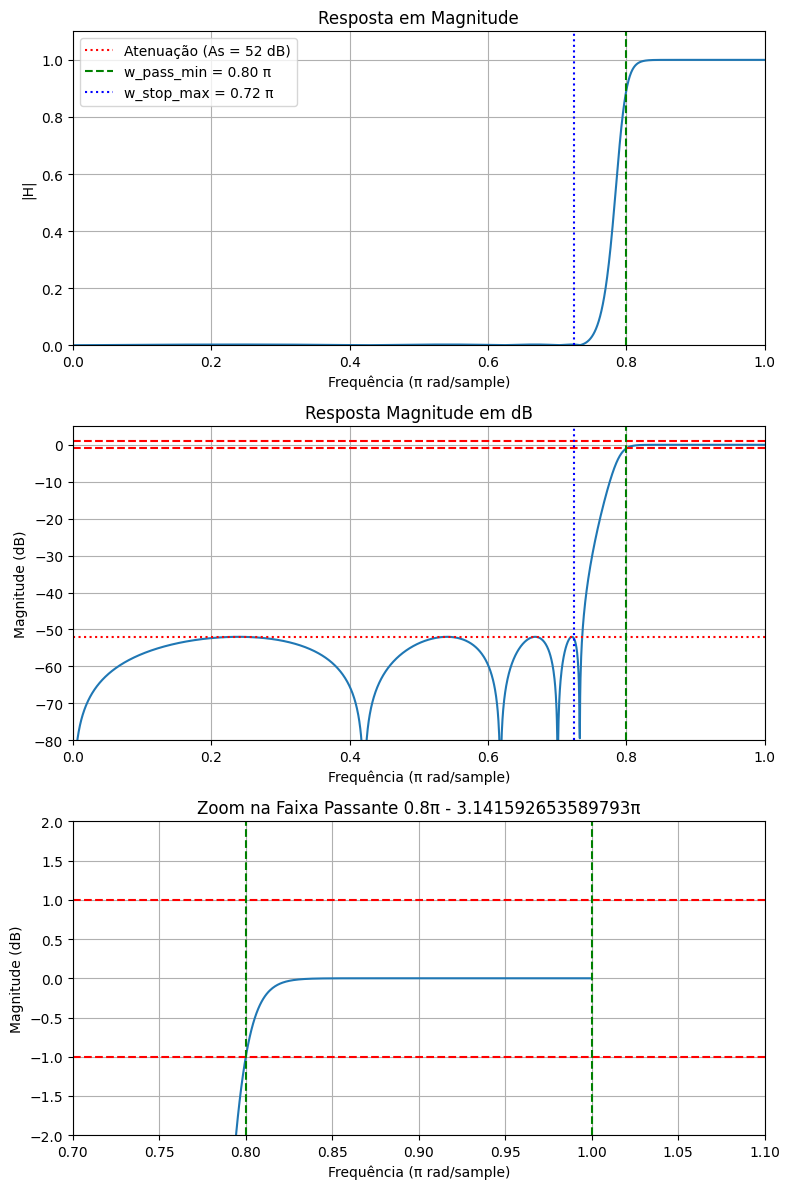

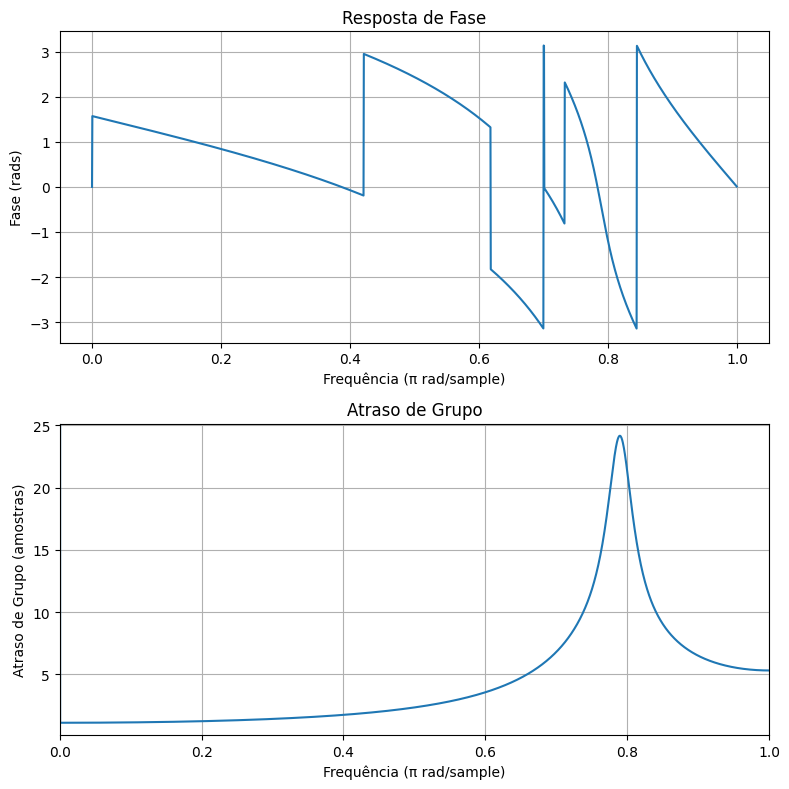

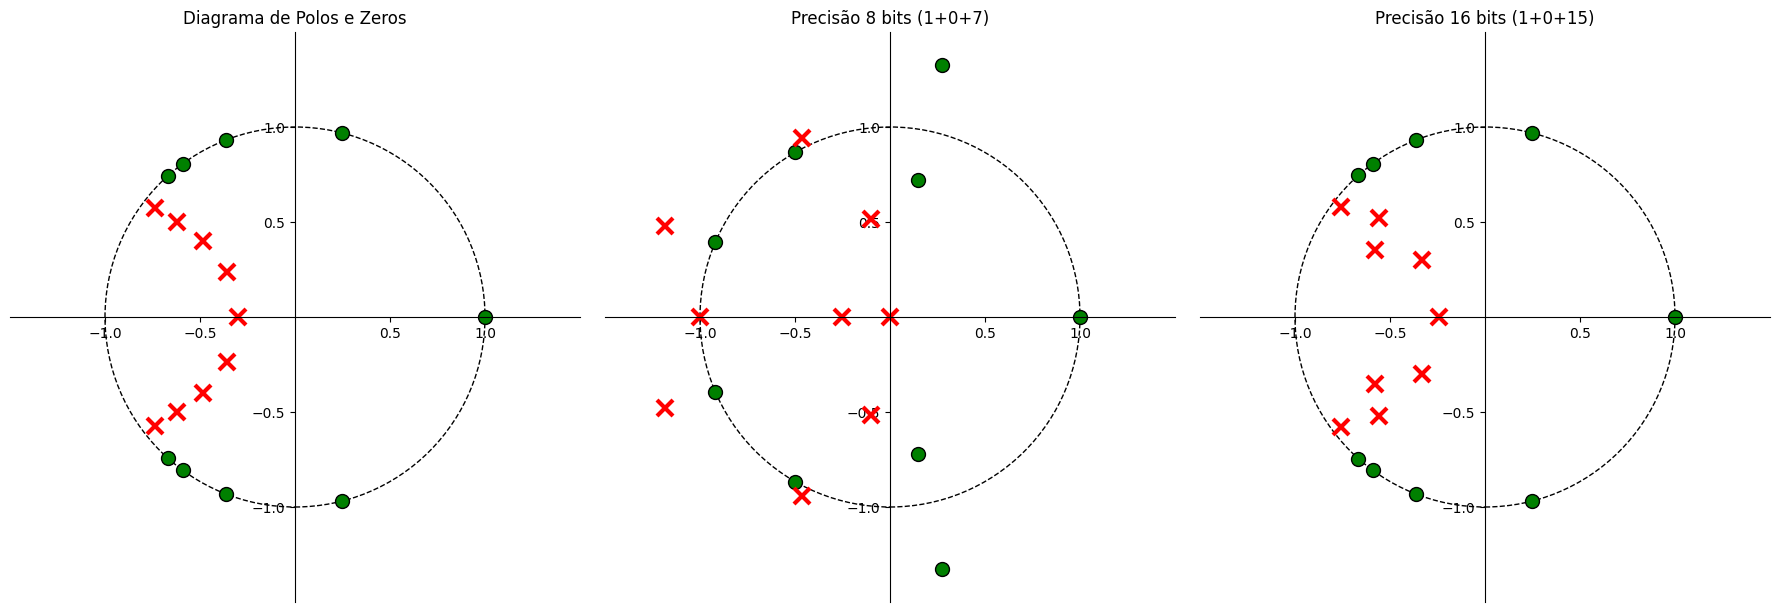

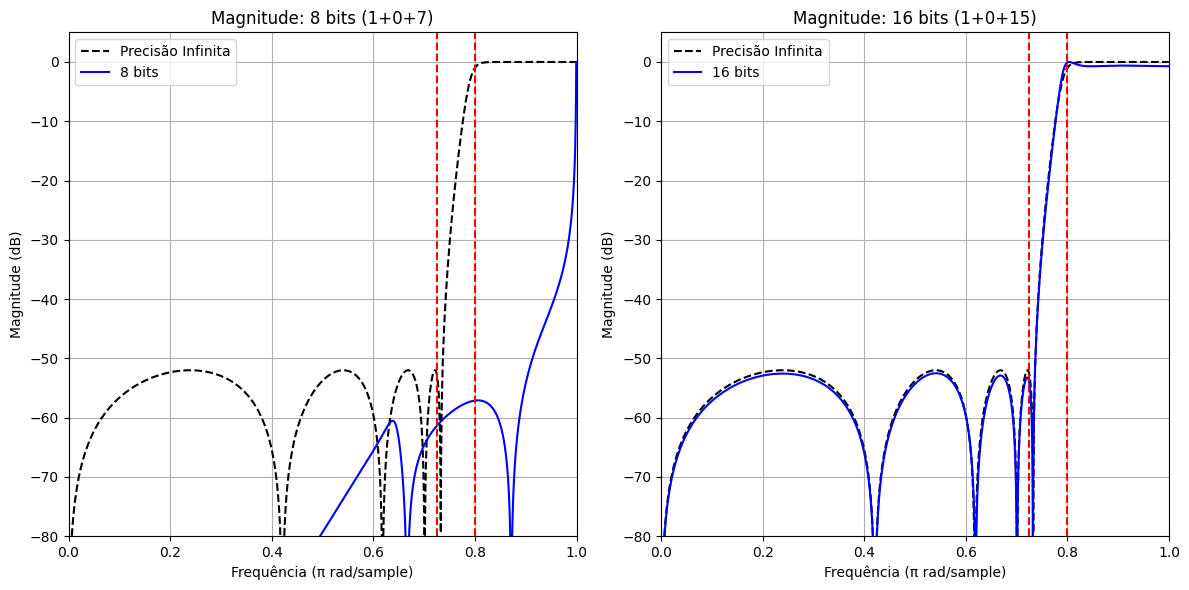

| **Filtro** | **Quantização** | **Ondulação (dB)** | **Atenuação (dB)** |
|:-----------:|:---------------:|:------------------:|:------------------:|
| chebyshev_ii | Infinita | 1.09 | 52.00 |
| chebyshev_ii | 8 bits | 110.07 | 60.53 |
| chebyshev_ii | 16 bits | 0.72 | 52.51 |



#### Calculo da ordem e multiplicações do filtro


Para determinar a ordem do filtro, vamos examinar o número de coeficientes presentes nos vetores fornecidos.

O filtro tem 10 coeficientes no numerador e 10 coeficientes no denominador.

Portanto, a ordem do filtro é $M = max(len(b), len(a)) - 1 = 9$.

Para determinar o número de multiplicações, vamos considerar a quantidade de coeficientes não nulos nos vetores de coeficientes.Desconsiderando o primeiro coeficiente, pois a multiplicação por 1 não é necessária.

O filtro possui 10 coeficientes não nulos no numerador e 10 coeficientes não nulos no denominador.

Logo, o número de multiplicações necessárias para implementar o filtro é $N - 1 + M - 1 = 18$.

#### Analisando as respostas do filtro



Para projetar o filtro passa-alta, utilizou-se o método Chebyshev II. Primeiramente, calculou-se a ordem do filtro N com base nas especificações do projeto, resultando em N = 9, utilizando a função `cheb2ord`. A frequência de corte foi determinada como $W_n = 0.7363$. Em seguida, projetou-se o filtro utilizando a função `signal.cheby2`, gerando os coeficientes do filtro passa-alta Chebyshev II 

b = [ 0.00638312  0.01116659  0.01951884  0.01220296  0.00851057 -0.00851057
 -0.01220296 -0.01951884 -0.01116659 -0.00638312], 
a = [1.00000000e+00 4.69585327e+00 1.04856736e+01 1.42736236e+01
 1.29443138e+01 8.05552069e+00 3.42747697e+00 9.57723416e-01
 1.59269528e-01 1.19270098e-02].

Assim como observado nos outros filtros, a representação em 8 bits compromete mais a qualidade do filtro Chebyshev II em comparação com a de 16 bits. A distribuição dos polos no diagrama de polos e zeros ilustra essa diferença. 

Em termos de magnitude, a quantização em 8 bits resulta em uma maior instabilidade, refletida na discrepância entre as respostas observadas (em preto) e as esperadas (em azul). A atenuação de 30 dB no filtro quantizado em 8 bits fica abaixo do valor mínimo de 40 dB exigido. Já o filtro quantizado em 16 bits apresenta respostas muito mais próximas das esperadas, com a atenuação adequada, mantendo o comportamento dentro dos parâmetros desejados.

In [7]:
# Definindo a atenuação mínima na faixa de parada e as frequências de passagem e parada
tr_width1 = abs(w_pass_min - w_stop_max)

# Calculando a ordem do filtro Chebyshev II
w_pass = w_pass_min / np.pi
w_stop = w_stop_max / np.pi
N, wn = signal.cheb2ord(w_pass, w_stop, pass_max_oscillation, stop_min_attenuation)

# Projetando o filtro Chebyshev II passa-alta
b, a = signal.cheby2(N, stop_min_attenuation, wn, btype='high', analog=False)

# Calculando as respostas em frequência
[db, mag, pha, grd, w] = freqz_m(b, a)

# Texto para o relatório

plot_filter_responses(b, fs, pass_max_oscillation, stop_min_attenuation, w_pass_min, w_pass_max, w_stop_max, 'chebyshev_ii', True, a)

display(Markdown("#### Analisando as respostas do filtro\n\n"))

display(Markdown(f"Para projetar o filtro passa-alta, utilizou-se o método Chebyshev II. "
                 f"Primeiramente, calculou-se a ordem do filtro N com base nas especificações do projeto, "
                 f"resultando em N = {N}, utilizando a função `cheb2ord`. "
                 f"A frequência de corte foi determinada como $W_n = {wn:.4f}$. "
                 f"Em seguida, projetou-se o filtro utilizando a função `signal.cheby2`, gerando os coeficientes "
                 f"do filtro passa-alta Chebyshev II \n\nb = {b}, \na = {a}."))

display(Markdown(f"Assim como observado nos outros filtros, a representação em 8 bits compromete mais a qualidade "
                 f"do filtro Chebyshev II em comparação com a de 16 bits. A distribuição dos polos no diagrama de "
                 f"polos e zeros ilustra essa diferença. \n\n"
                 f"Em termos de magnitude, a quantização em 8 bits resulta em uma maior instabilidade, refletida na "
                 f"discrepância entre as respostas observadas (em preto) e as esperadas (em azul). A atenuação de "
                 f"30 dB no filtro quantizado em 8 bits fica abaixo do valor mínimo de 40 dB exigido. "
                 f"Já o filtro quantizado em 16 bits apresenta respostas muito mais próximas das esperadas, com a "
                 f"atenuação adequada, mantendo o comportamento dentro dos parâmetros desejados."))


### Filtro Elípitico

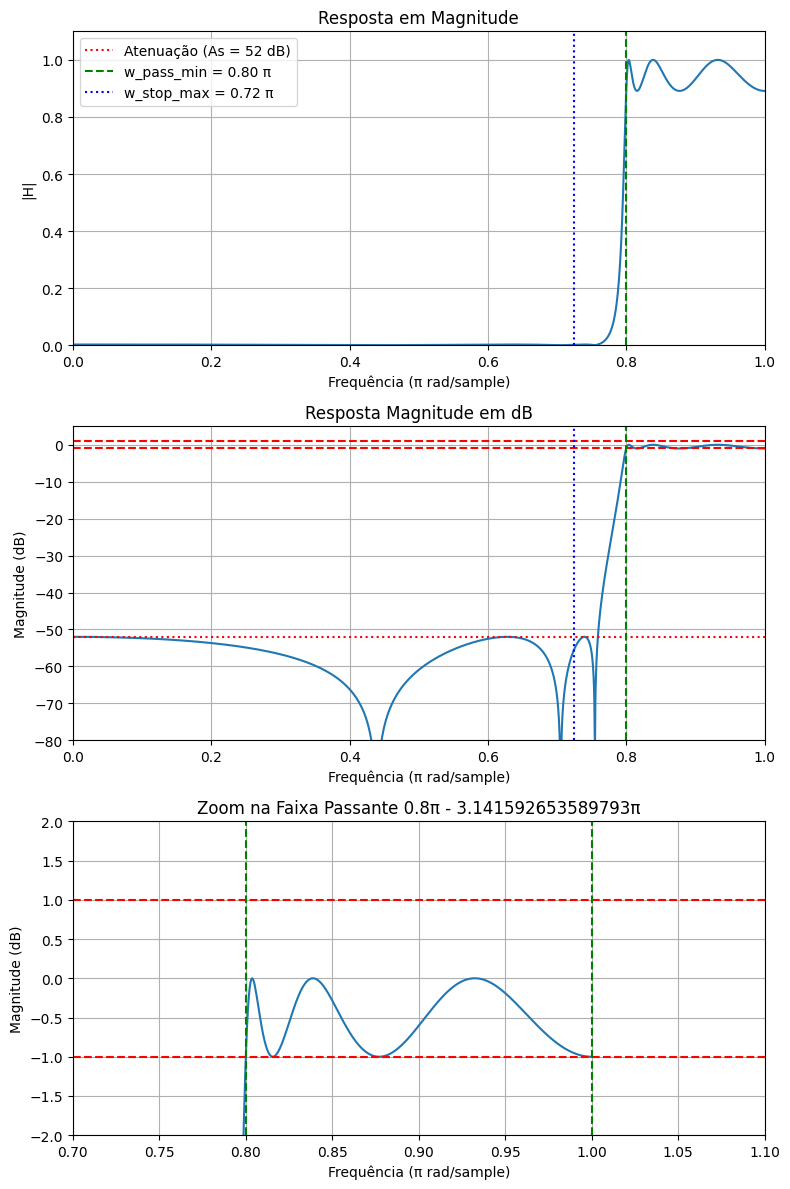

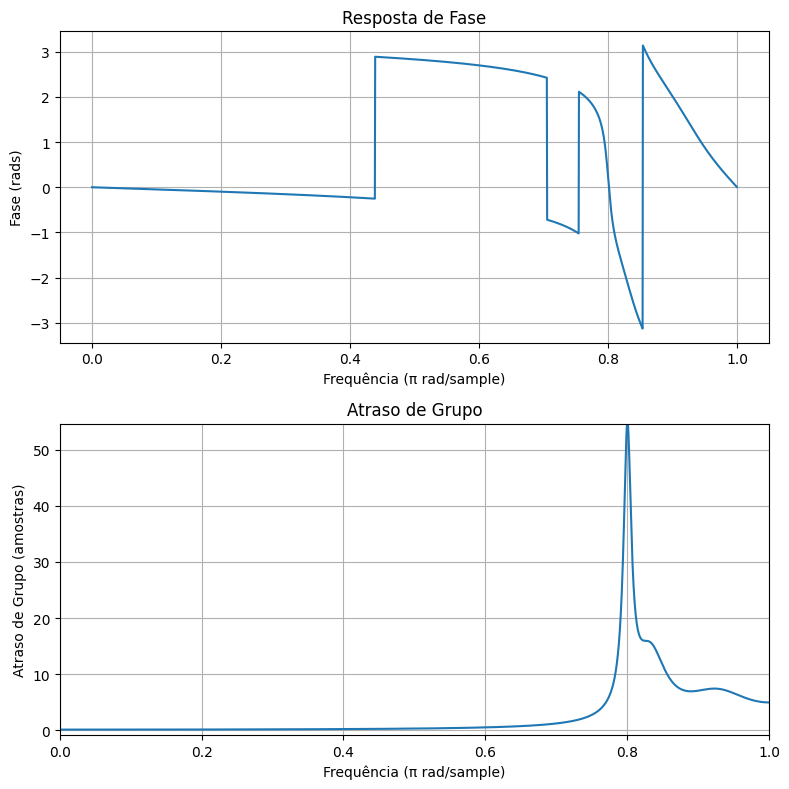

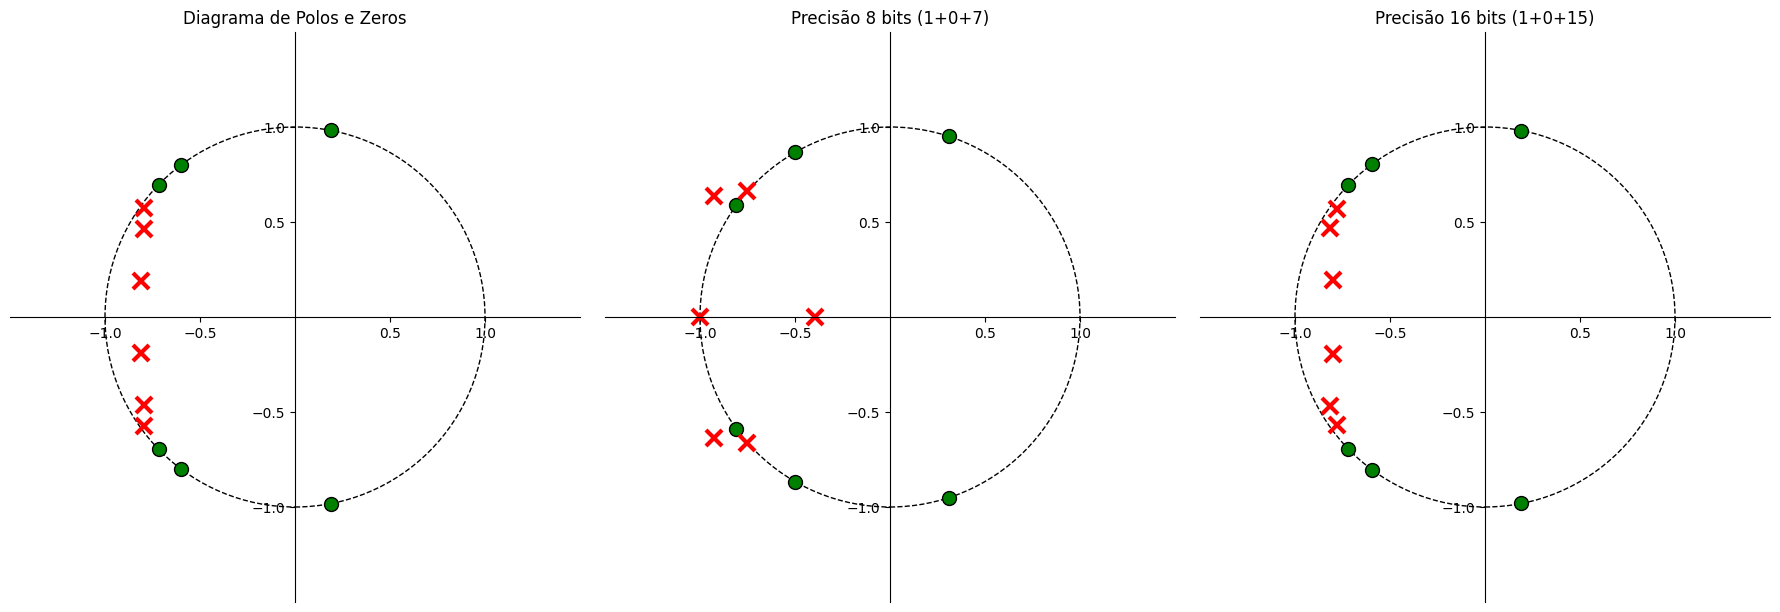

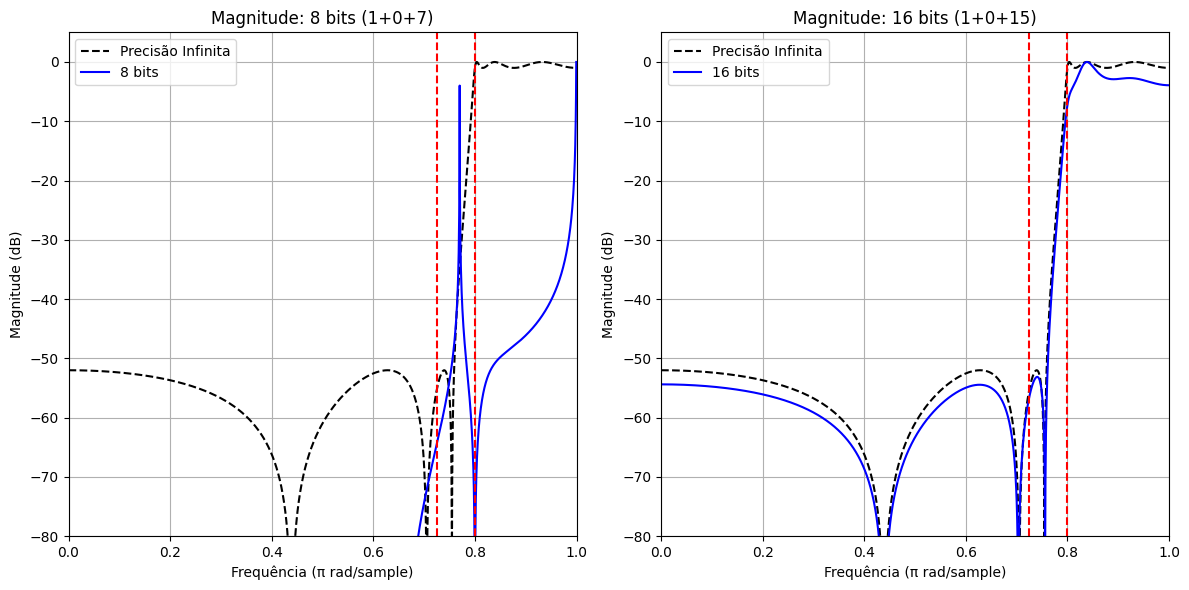

| **Filtro** | **Quantização** | **Ondulação (dB)** | **Atenuação (dB)** |
|:-----------:|:---------------:|:------------------:|:------------------:|
| elliptic | Infinita | 1.47 | 52.00 |
| elliptic | 8 bits | 92.79 | 64.61 |
| elliptic | 16 bits | 7.67 | 54.38 |



#### Calculo da ordem e multiplicações do filtro


Para determinar a ordem do filtro, vamos examinar o número de coeficientes presentes nos vetores fornecidos.

O filtro tem 7 coeficientes no numerador e 7 coeficientes no denominador.

Portanto, a ordem do filtro é $M = max(len(b), len(a)) - 1 = 6$.

Para determinar o número de multiplicações, vamos considerar a quantidade de coeficientes não nulos nos vetores de coeficientes.Desconsiderando o primeiro coeficiente, pois a multiplicação por 1 não é necessária.

O filtro possui 7 coeficientes não nulos no numerador e 7 coeficientes não nulos no denominador.

Logo, o número de multiplicações necessárias para implementar o filtro é $N - 1 + M - 1 = 12$.

#### Analisando as respostas do filtro



Para projetar o filtro passa-alta, foi utilizado o método Elíptico. Primeiramente, calculou-se a ordem do filtro N com base nas especificações do projeto, resultando em N = 6, utilizando a função `ellipord`. A frequência de corte foi determinada como $W_n = 0.8000$. Em seguida, o filtro foi projetado utilizando a função `signal.ellip`, gerando os coeficientes do filtro passa-alta Elíptico 

b = [0.00569359 0.01283957 0.02117395 0.02193741 0.02117395 0.01283957
 0.00569359], 
a = [ 1.          4.79640779 10.16529045 12.07586173  8.45098818  3.29870289
  0.5615589 ].

Assim como nos outros filtros, a representação em 8 bits compromete mais a qualidade do filtro Elíptico em comparação com a de 16 bits. A distribuição dos polos no diagrama de polos e zeros ilustra essa diferença. 

Em termos de magnitude, a quantização em 8 bits provoca maior instabilidade, refletida na diferença entre as respostas obtidas (em preto) e as esperadas (em azul). A magnitude do filtro quantizado em 8 bits apresenta uma atenuação de aproximadamente 30 dB, inferior à atenuação de 40 dB exigida. Por outro lado, o filtro quantizado em 16 bits gera respostas muito próximas das esperadas, mantendo o filtro dentro da faixa de atenuação desejada.

In [8]:
# Largura de transição
tr_width1 = abs(w_pass_min - w_stop_max)

# Frequências de corte normalizadas
w_pass = w_pass_min / np.pi
w_stop = w_stop_max / np.pi

# Calculando a ordem do filtro Elíptico
N, wn = signal.ellipord(w_pass, w_stop, pass_max_oscillation, stop_min_attenuation)

# Projetando o filtro Elíptico passa-alta
b, a = signal.ellip(N, pass_max_oscillation, stop_min_attenuation, wn, btype='high', analog=False)

# Calculando as respostas em frequência
[db, mag, pha, grd, w] = freqz_m(b, a)

# Texto para o relatório

plot_filter_responses(b, fs, pass_max_oscillation, stop_min_attenuation, w_pass_min, w_pass_max, w_stop_max, 'elliptic', True, a)

display(Markdown("#### Analisando as respostas do filtro\n\n"))

display(Markdown(f"Para projetar o filtro passa-alta, foi utilizado o método Elíptico. "
                 f"Primeiramente, calculou-se a ordem do filtro N com base nas especificações do projeto, "
                 f"resultando em N = {N}, utilizando a função `ellipord`. "
                 f"A frequência de corte foi determinada como $W_n = {wn:.4f}$. "
                 f"Em seguida, o filtro foi projetado utilizando a função `signal.ellip`, gerando os coeficientes "
                 f"do filtro passa-alta Elíptico \n\nb = {b}, \na = {a}."))

display(Markdown(f"Assim como nos outros filtros, a representação em 8 bits compromete mais a qualidade do filtro Elíptico "
                 f"em comparação com a de 16 bits. A distribuição dos polos no diagrama de polos e zeros ilustra essa diferença. \n\n"
                 f"Em termos de magnitude, a quantização em 8 bits provoca maior instabilidade, refletida na diferença "
                 f"entre as respostas obtidas (em preto) e as esperadas (em azul). A magnitude do filtro quantizado em 8 bits "
                 f"apresenta uma atenuação de aproximadamente 30 dB, inferior à atenuação de 40 dB exigida. "
                 f"Por outro lado, o filtro quantizado em 16 bits gera respostas muito próximas das esperadas, "
                 f"mantendo o filtro dentro da faixa de atenuação desejada."))


## Resultados

In [9]:
display(Markdown("## Ordem dos Filtros e Número de Multiplicações"))

tabela_markdown = ('| **Filtro** | **Ordem do filtro (M)** | **Números de Multiplicações** |\n'
				   '|:-----------:|:---------:|:---------------------------:|\n')

for filter_name, filter_data in filters_data.items():
	tabela_markdown += (f'| {filter_data.name} | {filter_data.order} | {filter_data.multiplications} |\n')


display(Markdown(tabela_markdown))


## Ordem dos Filtros e Número de Multiplicações

| **Filtro** | **Ordem do filtro (M)** | **Números de Multiplicações** |
|:-----------:|:---------:|:---------------------------:|
| fir_kaiser | 82 | 82 |
| fir_hamming | 138 | 138 |
| chebyshev_ii | 9 | 18 |
| elliptic | 6 | 12 |


In [10]:
comments = {
    'fir_kaiser': {
        8: "A quantização de 8 bits apresentou boa performance geral, porém a atenuação na banda de rejeição é significativamente menor do que o esperado.",
        16: "A precisão de 16 bits manteve a resposta quase ideal, com baixa ondulação na banda de passagem e atenuação suficiente na banda de rejeição."
    },
    'fir_hamming': {
        8: "	A quantização de 8 bits resultou em uma ondulação relativamente alta na banda de passagem, com atenuação insuficiente na banda de rejeição.",
        16: "Com 16 bits, o filtro exibiu uma excelente performance, com ondulação mínima e forte atenuação na banda de rejeição."
    },
    'chebyshev_ii': {
        8: "	A quantização de 8 bits levou a um comportamento anômalo, resultando em uma ondulação extremamente alta e instabilidade no filtro.",
        16: "A quantização de 16 bits gerou resultados estáveis, com ondulação e atenuação dentro das especificações."
    },
    'elliptic': {
        8: "O filtro elíptico quantizado em 8 bits exibiu uma ondulação excessiva na banda de passagem, tornando-o inadequado para uso com essa precisão.",
        16: "Embora o filtro elíptico tenha melhorado com 16 bits, a ondulação na banda de passagem ainda está acima do ideal, mas a atenuação na banda de rejeição está aceitável."
    }
}

display(Markdown("## Ordem dos Filtros e Número de Multiplicações"))

tabela_markdown = ('| **Filtro** | **Precisão (Bits)** | **Ondulação Banda de Passagem** | **Atenuação Banda de Rejeição 1** | **Comentários** |\n'
                '|:-----------:|:---------------------:|:-------------------------------:|:---------------------------------:|:--------------:|\n')
# Separando os filtros por quantidade de bits e tipo
for filter_name, filter_data in filters_data.items():
    tabela_markdown += (f'| {filter_data.name} | 8 | {filter_data.ripple_calculado_8bits:.3f} dB | {filter_data.attenuation_calculado_8bits:.3f} dB | {comments[filter_name][8]} |\n')
    tabela_markdown += (f'| {filter_data.name} | 16 | {filter_data.ripple_calculado_16bits:.3f} dB | {filter_data.attenuation_calculado_16bits:.3f} dB | {comments[filter_name][16]} |\n')

display(Markdown(tabela_markdown))


## Ordem dos Filtros e Número de Multiplicações

| **Filtro** | **Precisão (Bits)** | **Ondulação Banda de Passagem** | **Atenuação Banda de Rejeição 1** | **Comentários** |
|:-----------:|:---------------------:|:-------------------------------:|:---------------------------------:|:--------------:|
| fir_kaiser | 8 | 0.714 dB | 26.943 dB | A quantização de 8 bits apresentou boa performance geral, porém a atenuação na banda de rejeição é significativamente menor do que o esperado. |
| fir_kaiser | 16 | 0.054 dB | 52.361 dB | A precisão de 16 bits manteve a resposta quase ideal, com baixa ondulação na banda de passagem e atenuação suficiente na banda de rejeição. |
| fir_hamming | 8 | 0.936 dB | 23.971 dB | 	A quantização de 8 bits resultou em uma ondulação relativamente alta na banda de passagem, com atenuação insuficiente na banda de rejeição. |
| fir_hamming | 16 | 0.030 dB | 55.950 dB | Com 16 bits, o filtro exibiu uma excelente performance, com ondulação mínima e forte atenuação na banda de rejeição. |
| chebyshev_ii | 8 | 110.066 dB | 60.533 dB | 	A quantização de 8 bits levou a um comportamento anômalo, resultando em uma ondulação extremamente alta e instabilidade no filtro. |
| chebyshev_ii | 16 | 0.724 dB | 52.506 dB | A quantização de 16 bits gerou resultados estáveis, com ondulação e atenuação dentro das especificações. |
| elliptic | 8 | 92.789 dB | 64.605 dB | O filtro elíptico quantizado em 8 bits exibiu uma ondulação excessiva na banda de passagem, tornando-o inadequado para uso com essa precisão. |
| elliptic | 16 | 7.669 dB | 54.381 dB | Embora o filtro elíptico tenha melhorado com 16 bits, a ondulação na banda de passagem ainda está acima do ideal, mas a atenuação na banda de rejeição está aceitável. |


### Análise
- **Quantização de 8 bits:** Ao contrário de muitos casos típicos onde os filtros quantizados com 8 bits apresentam grandes problemas, nos seus resultados, os filtros FIR com janelas Kaiser e Hamming ainda tiveram desempenho minimamente usável, com ondulações controladas na banda de passagem e atenuação razoável, porém fora das especificações. No entanto, os filtros Chebyshev II e Elíptico apresentaram grandes ondulações na banda de passagem, tornando-os inadequados com essa precisão.
- **Quantização de 16 bits:** Com 16 bits, todos os filtros mostraram desempenho satisfatório, atendendo às especificações de projeto, com baixa ondulação na banda de passagem e atenuação suficiente na banda de rejeição. Mesmo os filtros Chebyshev II e Elíptico, que tiveram comportamento problemático com 8 bits, funcionaram bem em 16 bits, embora o Elíptico tenha mostrado uma leve ondulação acima do ideal.

## Diferenças no Atraso de Fase e Tipo de Fase

### Filtros FIR
- **Janela Kaiser:** O filtro FIR com janela Kaiser apresentou uma fase linear e um atraso de grupo constante na banda de passagem, o que é essencial em aplicações que exigem preservação do formato do sinal.
- **Janela Hamming:** Similar ao filtro Kaiser, o filtro Hamming também exibiu uma fase linear, garantindo a coerência temporal do sinal filtrado. Ambas as janelas mantêm a forma do sinal sem distorções.

### Filtros IIR
- **Chebyshev II:** Com fase não linear, o filtro Chebyshev II introduz diferentes atrasos para diferentes componentes de frequência, o que pode causar distorção de fase. Ainda assim, ele apresentou uma rejeição de banda muito eficiente em 16 bits.
- **Elíptico:** O filtro elíptico, apesar de ser altamente seletivo, também apresentou fase não linear e, em 8 bits, gerou uma grande ondulação na banda de passagem. Em 16 bits, o comportamento melhorou, mas a distorção de fase continua presente devido à sua natureza.

### Análise
- **Fase Linear vs. Não Linear:** Os filtros FIR, com suas fases lineares, são a melhor escolha quando a preservação da forma do sinal é crucial, como em comunicações e áudio. Por outro lado, os filtros IIR, embora mais eficientes em termos de ordem e uso de recursos, introduzem distorções de fase que podem ser problemáticas em aplicações onde a coerência temporal é importante.

## Conclusões

Este estudo realizou uma análise detalhada dos filtros digitais, explorando diferentes métodos de implementação e efeitos da quantização. Foram implementados filtros FIR (usando janelas de Kaiser e Hamming) e IIR (Chebyshev II e Elíptico), com foco na comparação em termos de ordem, número de multiplicações e comportamento nas respostas em frequência, incluindo as distorções de fase.

## Principais Conclusões:

1. **Ordem e Eficiência Computacional:**
   - Os filtros FIR, especialmente os projetados com janelas Kaiser e Hamming, exigem ordens mais altas, resultando em um número maior de multiplicações. No entanto, sua fase linear os torna mais adequados para aplicações que demandam a preservação precisa da forma do sinal.
   - Já os filtros IIR, como Chebyshev II e Elíptico, têm ordens menores, tornando-os mais eficientes em termos de custo computacional. Contudo, sua fase não linear pode causar distorções temporais, o que os torna menos indicados para aplicações onde a integridade da forma do sinal é crítica.

2. **Impacto da Quantização:**
   - A quantização em 8 bits, embora funcional para alguns filtros FIR, como os de janela Kaiser, resultou em desempenho comprometido nos filtros IIR, com grandes ondulações na banda de passagem e insuficiente atenuação na banda de rejeição. Em filtros mais sensíveis, como o Elíptico, essa quantização gerou ondulações inaceitáveis.
   - A quantização em 16 bits melhorou significativamente o desempenho dos filtros, permitindo que a maioria atendesse às especificações de projeto. Mesmo assim, em alguns casos, pequenas distorções ainda podem surgir, especialmente nos filtros IIR.

3. **Distorções de Fase:**
   - Os filtros FIR, tanto Kaiser quanto Hamming, mantiveram uma fase linear, essencial para aplicações que exigem a preservação da coerência temporal do sinal.
   - Os filtros IIR, por sua vez, introduziram distorções de fase, característica intrínseca desses tipos de filtros devido à sua resposta infinita ao impulso. Isso pode ser problemático em sistemas que requerem alta precisão temporal.

## Considerações Finais:

A escolha entre filtros FIR e IIR depende das exigências específicas da aplicação. Filtros FIR são recomendados quando a linearidade da fase é uma prioridade, mesmo que isso implique em maior complexidade computacional. Por outro lado, os filtros IIR são mais eficientes para cenários onde é necessário processamento rápido e econômico, mas suas distorções de fase precisam ser levadas em consideração. Além disso, a quantização dos coeficientes é crucial para garantir que o desempenho do filtro atenda aos requisitos, com a quantização em 16 bits oferecendo um equilíbrio entre precisão e eficiência computacional.